# Diffusion Model

The objective of this project is to get hands-on experience in implementing Denoising Diffusion Probabilistic Models (DDPMs)

### Conda environment

GPU version:
```
conda env create -f environments/diffusion_gpu.yml
```
CPU version:
```
conda env create -f environments/diffusion_cpu.yml
``` 

In [1]:
import torch

from torch import nn

from datasets import load_dataset

import numpy as np
import math
import matplotlib.pyplot as plt
import os
from tests import *
from utils import *

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from functools import partial
from torch.nn import functional as F
from collections.abc import Callable
from typing import Union
from livelossplot import PlotLosses

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "./results/"

%load_ext autoreload
%autoreload 2

/apps/Arch/software/tqdm/4.64.0-GCCcore-11.3.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will first generate and use simple 2D 4-Gaussians data.

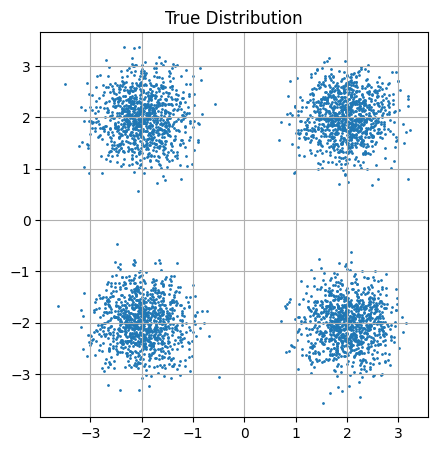

In [3]:
# Have the code to produce and visualize the 2D data that we want to consider

def generate_mixture_of_gaussians(num_samples: int = 1000) -> np.ndarray:
    # If you go outside -4,4 you will need to update the xlim and ylim arguments to vis_2d :)
    means = [[-2, -2], [2, 2], [-2, 2], [2, -2]]
    cov = np.eye(2) * 0.2
    samples = []
    for mean in means:
        samples.append(
            np.random.multivariate_normal(mean, cov, size=num_samples // len(means))
        )
    return np.vstack(samples)

data_gaussians_2d = torch.tensor(generate_mixture_of_gaussians(4000), dtype=torch.float32)

plot_2D(data_gaussians_2d, xlim=(-4, 4), ylim=(-4, 4))

The idea behind diffusion based generative models is to sequentially add noise to a data sample so that it eventually becomes indistinguishible from pure noise and somehow learn to model the reverse process of noise addition so that it is possible to generate data starting from pure noise.

The forward process is a Markov process adding small Gaussian noise to the sample (along with some scaling) at the previous timstep. It can be formulated as:

\begin{equation*}
\large q(x_{t} |  x_{t-1}) = \mathcal{N}(x_{t}; \sqrt{1 - \beta_{t}} x_{t-1}, \beta_{t} \mathbf{I})
\tag{1}
\end{equation*}

To implement this forward process, we first neede a sequence $ \{ \beta_{t} |  t = 1,2 \dots ,T\}$. Complete the function below to obtain a simple linear beta schedule.

In [28]:
def linear_beta_schedule(beta_start: float = 1e-4, 
                         beta_end: float = 0.02,
                         num_timesteps: int = 200):
    
    # Function that returns linearly spaced betas
    # Inputs:   beta_start: float,
    #           beta_end: float,
    #           num_timesteps: int
    
    # Output:   betas: torch.Tensor

    betas = torch.linspace(beta_start, beta_end, num_timesteps)
    
    return betas

In [5]:
test_linear_beta_schedule(linear_beta_schedule)

✓ Value test passed! 


With the beta schedule implemented, it is time for the forward diffusion process. Complete the function `forward_sequential_diffusion` below to have it produce a trajectory of samples at all timesteps. This is not really needed for the training process, however, it provides a good visualization of the forward process.

In [26]:
def extract(a: torch.Tensor, t: Union[int, torch.Tensor], x: torch.Tensor):

    # Function that extracts the value of a tensor at given time steps
    
    # Inputs:   a: torch.Tensor,
    #           t: Union[int, torch.Tensor],
    #           x: torch.Tensor
    
    # Output:   out: torch.Tensor

    batch_size = x.shape[0]
    out = a.gather(-1, torch.full((batch_size,), t) if isinstance(t, int) else t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x.shape) - 1))).to(x.device)

In [27]:
def forward_sequential_diffusion(betas: torch.Tensor, alphas: torch.Tensor, x_0: torch.Tensor = None):
        
    # Add noise to the input at each timestep to produce a list of noisy samples
    
    # Input:    betas: torch.Tensor (shape - (num_timesteps, ))
    #           x_0: torch.Tensor -  A single data element (any shape)
    
    # Output: noisy_samples (list of noisy samples of len self.num_timesteps each element with shape - x_0.shape)

    num_timesteps = betas.shape[0]
    noisy_samples = []
    x_tm1 = x_0

    for t in range(num_timesteps):
        # Use equation (1) from above
        
        x_t = torch.normal(torch.sqrt(1-betas[t])*x_tm1, torch.sqrt(betas[t]))
        
        noisy_samples.append(x_t)
        
        x_tm1 = x_t
    
    return noisy_samples

Check using the visualization below if your sequential forward process is reasonable. The points should move towards a standard Gaussian distribution in 2D. Since the computation of exact probability densities is not possible here (unlike the normalizing flows assignment), we use an emperical method based on Gaussian kernels to visualize the probability density. 

Creating plots for visualizations... Computing densities is slow


200it [00:20,  9.67it/s]


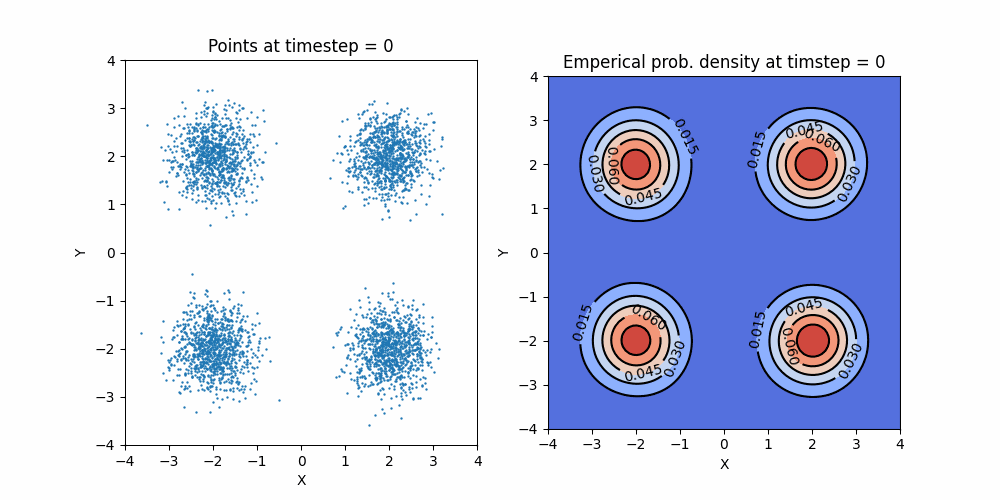

In [8]:
# Number of timesteps
num_timsteps = 200

# Initial data
x_0 = data_gaussians_2d

# Linearly spaced betas
betas = linear_beta_schedule(num_timesteps = num_timsteps)

# Forward diffusion
alphas = 1 - betas
x_ts = forward_sequential_diffusion(betas, alphas, x_0)

# Output directory
output_dir = './results/forward_2d'

visualize_2D_steps(x_ts, range(num_timsteps), plot_every = num_timsteps//20, output_dir=output_dir)
create_gif(output_dir, prefix='timestep')


Now that you have gotten a feel of the forward process, we will use the trick to compute a noisy sample at a random timestep without going through all the timesteps. First explain below, using the involved math (especially, the step of merging 2 Gaussians) on how you can sample from the forward process directly at timestep t? Use the standard notation ( $\alpha, \bar{\alpha}$ ) to allow the reader to follow your argument easily.

$$\alpha_t = 1-\beta_t$$
$$\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$$
$$\epsilon_{t-1}, \epsilon_{t-2}, \dots \sim \mathcal{N}(0,I)$$
$$
\begin{align}
x_t & = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon_{t-1} 
\\
& = \sqrt{\alpha_t} \left (\sqrt{\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_{t-1}}\epsilon_{t-2} \right) + \sqrt{1-\alpha_t}\epsilon_{t-1} 
\\
& = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{\alpha_t(1-\alpha_{t-1})}\epsilon_{t-2} + \sqrt{1-\alpha_t}\epsilon_{t-1} \\
& = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t \alpha_{t-1}}\bar{\epsilon}_{t-2}\\
& = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\bar{\epsilon}_0
\end{align}
$$

Thus, we can calculate $\bar{\alpha}_{t} = \prod_{i=1}^t \alpha_i$ to produce noisy sample at a chosen set of timesteps.

In [ ]:
def produce_noisy_samples(x_0: torch.Tensor,
                          ts: torch.Tensor,
                          alphas_bar: torch.Tensor,
                          noise: torch.Tensor):
          
    # Add noise to the input tensor at random timesteps to produce a tensor of noisy samples

    # Input: x_0 - [batch_size * [any shape]] 
    #        ts  - [batch_size,]
    #        alphas_bar - [num_timesteps,]
    #        noise - *[x_0.shape]

    # Output: noisy_samples (tensor of noisy samples of shape - x_0.shape)

    alphas_bar = extract(alphas_bar, ts, x_0)
    x_t = torch.sqrt(alphas_bar) * x_0 + torch.sqrt(1 - alphas_bar) * noise
    
    return x_t

In [10]:
test_produce_noisy_samples(produce_noisy_samples)

✓ Shape test passed! 
✓ Value test passed! 


It is now time to implement the reverse diffusion process so that it is possible to produce new samples at inference time. First implement the following function that takes one step back given the predicted noise. We will of course later see how to predict this noise. Recall the learnt backward step is written as:

\begin{equation*}
p_{\theta} (x_{t-1} | x_t) = \mathcal{N} (x_{t-1}; \frac{1}{\sqrt{\alpha_{t}}} \left( x_{t}  -  \frac{1- \alpha_{t}}{\sqrt{1 - \bar{\alpha_{t}}}} \epsilon_{\theta}(x_{t}, t) \right), \sigma^{2} \mathbf{I} )
\tag{2}
\end{equation*}

where $\sigma^{2}$ is called `posterior_variance` in the code below. Refer to the algorithm 2 of the DDPM paper for the full sampling algorithm. <b>NOTE</b>: Here, you only implement a single step of that.

In [24]:
def step_back(x_t: torch.Tensor,
              t: int,
              betas : torch.Tensor,
              alphas: torch.Tensor,
              alphas_bar: torch.Tensor,
              posterior_variance: torch.Tensor,
              pred_noise: torch.Tensor):
    
    # Denoise the input tensor at a given timestep using the predicted noise

    # Input: x_t (any shape),
    #        t (timestep at which to denoise),
    #        predicted_noise (noise predicted at the timestep)

    # Output: x_tm1 (x[t-1] denoised sample by one step - x_t.shape)

    betas_t = extract(betas, t, x_t)
    alphas_t = extract(alphas, t, x_t)
    alphas_bar_t = extract(alphas_bar, t, x_t)
    posterior_variance_t = extract(posterior_variance, t, x_t)
    
    if t > 0:
        z = torch.randn_like(x_t)
    else:
        z = 0

    return 1/ torch.sqrt(alphas_t) * (x_t - (1 - alphas_t) / torch.sqrt(1 - alphas_bar_t) * pred_noise) + torch.sqrt(posterior_variance_t) * z


Let us organize the previously defined functions of managing the noise and noisy samples into a single class to keep things organized. Complete the constructor to precompute the $\beta_{t}$, $\alpha_{t}$, $\bar{\alpha}_{t}$ and any other variables that you might need later. Complete the associated methods by calling the previously completed functions appropriately.

In [16]:
class NoiseScheduler:

    def __init__(self, beta_schedule: Callable, num_timesteps = 200, posterior_variance = 'beta',):
        
        self.num_timesteps = num_timesteps
        
        # define beta
        self.betas = beta_schedule(num_timesteps = num_timesteps)   
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)

        # Two different values of posterior variance (sigma ** 2) proposed of the authors 
        if posterior_variance == 'beta':
            self.posterior_variance = self.betas
        elif posterior_variance == 'beta_tilde':
            self.posterior_variance = self.betas * (1. - F.pad(self.alphas_bar[:-1], (1, 0), value=1.0)) / (1. - self.alphas_bar)
        else:
            raise NotImplementedError
        
    
    # Sampling from the forwad process
    def q_sample(self,
                x_0: torch.Tensor,
                ts: torch.Tensor,
                noise: torch.Tensor):
          
        # Add noise to the input tensor at random timesteps to produce a tensor of noisy samples

        # Input: x_0 (any shape), 
        #        ts (tensor of timesteps at which to add noise)

        # Output: noisy_samples (tensor of noisy samples of shape - x_0.shape)

        x_t = produce_noisy_samples(x_0, ts, self.alphas_bar, noise)
        
        return x_t
    
    # Sampling from the backward prcess - Use the step back function in a loop appropriately here

    @torch.no_grad()
    def sample(self,
            model: nn.Module,
            num_samples: int,
            device: torch.device, 
            shape: tuple):

        # Sample points from the data distribution

        # Input: model (model to predict noise)
        #        num_samples (number of samples)
        #        device (the device the model is on)
        #        shape (shape of data, e.g., (1, 28, 28))

        # Output: all x through the (predicted) reverse diffusion steps

        model.eval()
        steps = []

        x_tm1 = torch.randn((num_samples,) + shape).to(device)
        
        for t in reversed(range(0, self.num_timesteps)):

            t_tensor = torch.full((x_tm1.shape[0],), t, device=device)
            
            # Use the model to predict noise and use the noise to step back 
            pred_noise = model(x_tm1, t_tensor)

            x_tm1 = step_back(x_tm1, t, self.betas, self.alphas, self.alphas_bar, self.posterior_variance, pred_noise)

            steps.append(x_tm1.detach().cpu())

        return x_tm1.detach().cpu(), steps

At this point, we have implemented enough components of the diffusion process to be able to train a model to denoise. We do of course need a neural network which we will implement now. But before that, you are encouraged to think about the training objective. At a very high level, describe below, how does maximizing the log probability of training examples, boils down to just regressing over the actual noise sampled at different timesteps. This is for your intuition! 

At a "very high level", the intuition of the training objective could be thought of as in order to achieve the ultimate goal- to reconstruct the data distribution from the noisy one, the model needs to at each time step learn the regression task of how to remove a certain amount of noise.

Now that we have an idea of what the objective is and hence, what the network output should look like, let us design the network. For the task of 2D mixture of Gaussians, a simple MLP network should be enough. You will complete the network class `NoisePredictorNetwork` below that takes in the time and a noisy data sample at time $t$ as input to return the predicted noise. You should use sinuoidal embeddings for the timesteps as done by J. Ho. et al. (Denoising Diffusion Probabilistic Models).   

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor):
        device = time.device
        embeddings = 1. / 10000 ** (2. / self.dim * torch.tensor([i // 2 for i in range(self.dim)], device=device))
        embeddings = time[:, None] * embeddings[None, :]
        embeddings[:, ::2] = embeddings[:, ::2].sin()
        embeddings[:, 1::2] = embeddings[:, 1::2].cos()

        return embeddings

In [6]:
class NoisePredictorBlock(nn.Module):

    # An MLP block with LeakyRelu activation

    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x: torch.Tensor):
        
        return x + self.act(self.ff(x))


class NoisePredictorNetwork(nn.Module):

    # The embedding type can be experimented between learned and sinusoidal to compare the preformance 

    def __init__(self, in_dim: int, hidden_size: int = 128, emb_size: int = 128, out_dim: int = 1):

        super().__init__()

        self.time_embedding = SinusoidalPositionEmbeddings(emb_size)
        self.input_mlp = nn.Sequential(
            nn.Linear(in_dim, emb_size),
            nn.LeakyReLU(0.2),
        )
        layers = [
            nn.Linear(2 * emb_size, hidden_size),
            nn.LeakyReLU(0.2),
            NoisePredictorBlock(hidden_size),
            NoisePredictorBlock(hidden_size),
            nn.Linear(hidden_size, out_dim),
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        
        time_emb = self.time_embedding(t)
        x_emb = self.input_mlp(x)
        # Concatenate the time embedding and the input embedding
        x = torch.cat([x_emb, time_emb], dim=-1)
        
        return self.net(x)

Now we can move onto defining the training function. Complete the missing parts below. Make sure all variables are on the same device.

In [15]:
def train(model, optimizer, num_epochs, dataloader_train, noise_scheduler, device):

    fig, ax = plt.subplots(1,1, figsize = (6, 6))
    avg_losses = []
    global_steps = []
    losses = []

    model.to(device)
    global_step = 0
    
    for epoch in range(num_epochs):
        
        model.train()
        
        total_loss = 0.

        for step, batch in enumerate(dataloader_train):
            batch = batch.to(device)
            
            global_step += 1
            
            # sample a tensor of random timesteps
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).to(device)
            
            # sample random noise for the batch
            true_noise = torch.randn_like(batch).to(device)
            
            # YOUR CODE HERE
            noisy_batch = noise_scheduler.q_sample(batch, timesteps, true_noise)
            predicted_noise = model(noisy_batch, timesteps)

            loss = F.mse_loss(predicted_noise, true_noise)

            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            # progress_bar.update(1)
            total_loss += loss.detach().item()
            losses.append(loss.detach().item())

            if (global_step % 20 == 0) and (step >= 10):
                
                global_steps.append(global_step)
                avg_losses.append(sum(losses[-10:])/10.0)
                
                print(f"Steps : {global_steps[-1]}, Average loss for last 10 steps : {avg_losses[-1]}")

            
        ax.plot(global_steps, avg_losses)
        ax.set_title("Loss")

Finally, train your denoising network for the 2D mixture of Gaussians classmethod. If everything has been implemented well, the loss should go lower than 0.45.

Steps : 20, Average loss for last 10 steps : 0.6487776219844819
Steps : 40, Average loss for last 10 steps : 0.5022857010364532
Steps : 60, Average loss for last 10 steps : 0.4597943663597107
Steps : 80, Average loss for last 10 steps : 0.4372406542301178
Steps : 100, Average loss for last 10 steps : 0.43491332828998563
Steps : 120, Average loss for last 10 steps : 0.4269325345754623
Steps : 140, Average loss for last 10 steps : 0.4217169791460037
Steps : 160, Average loss for last 10 steps : 0.41163178980350495
Steps : 180, Average loss for last 10 steps : 0.4148238033056259
Steps : 220, Average loss for last 10 steps : 0.41644504070281985
Steps : 240, Average loss for last 10 steps : 0.4296981394290924
Steps : 260, Average loss for last 10 steps : 0.4204293727874756
Steps : 280, Average loss for last 10 steps : 0.4004890710115433
Steps : 300, Average loss for last 10 steps : 0.4094714730978012
Steps : 320, Average loss for last 10 steps : 0.40768775045871736
Steps : 340, Average loss

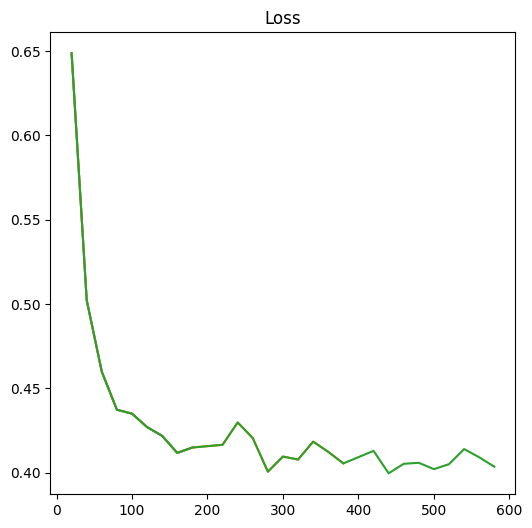

In [16]:
num_points_dataset = 200000
data_gaussians_2d = torch.tensor(generate_mixture_of_gaussians(num_points_dataset), dtype=torch.float32)
linear_beta = partial(linear_beta_schedule, beta_start=1e-3, beta_end=0.1)
noise_scheduler_2d_pts = NoiseScheduler(beta_schedule=linear_beta, num_timesteps=100)

# Get the torch dataloader
dataloader_train_2d_pts = torch.utils.data.DataLoader(data_gaussians_2d, batch_size = 1024, shuffle = True)

# Pass the num_timesteps argument if you want to use learnable embeddings for time
model = NoisePredictorNetwork(in_dim=2,
                              hidden_size=128,
                              emb_size= 128,
                              out_dim=2)

# Declare the optimizer
optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )
    
num_epochs = 3

train(model = model,
      optimizer = optimizer,
      num_epochs = num_epochs,
      dataloader_train = dataloader_train_2d_pts,
      noise_scheduler = noise_scheduler_2d_pts,
      device = DEVICE)

Now we can sample from the backward process, starting from 2D standard Gaussian noise to generate new sample that should look like the training data.

Creating plots for visualizations... Computing densities is slow


100it [00:19,  5.14it/s]


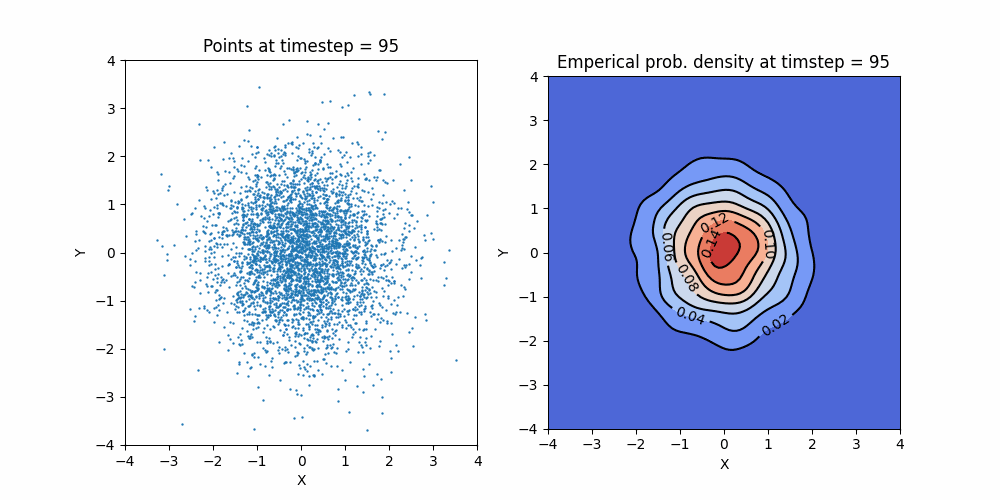

In [17]:
model.eval()
model.to("cpu")

num_pts = 4000
pts_shape = (2,1)

sample, steps = noise_scheduler_2d_pts.sample(model, num_pts, device="cpu", shape=(2,))

output_dir = "./results/reverse_2d/"

visualize_2D_steps(x_ts = steps,
                    timesteps = reversed(range(noise_scheduler_2d_pts.num_timesteps)),
                    output_dir = output_dir,
                    plot_every = noise_scheduler_2d_pts.num_timesteps//20,
                    plot_densities = True)

create_gif(output_dir, prefix = "timestep", reverse= True, gif_name = "samples_reverse.gif")

## Score based generative modelling through stochastic differential equations

Let us consider continuous time instead. The diffusion process is defined by the following SDE (called Variance Preserving (VP) SDE):

$dx_t = -\dfrac{1}{2} \beta(t) x_t \; dt + \sqrt{\beta(t)} \; dw_t, \quad\quad t \in [0, 1]$. 

Here we let $\beta(t) = \bar{\beta}_{\rm min} + t (\bar{\beta}_{\rm max} - \bar{\beta}_{\rm min})$ where $\bar{\beta}_{\rm min} = 0.1$ and $\bar{\beta}_{\rm max} = 20$.

In [18]:
def beta(t, beta_bar_min=0.1, beta_bar_max=20.):
    return beta_bar_min + t * (beta_bar_max - beta_bar_min)

Then, the diffusion process for an arbitrary time step $t$ is

$q_t(x_t|x_0) = \mathcal{N}(x_t; \gamma_t x_0, \sigma_t^2 I)$ with

* $\gamma_t = e^{-\frac{1}{2} \int_0^t \beta(s) \; ds}$.
* $\sigma_t^2 = 1 - e^{- \int_0^t \beta(s) \; ds}$.

In [19]:
def fit_shape(t: torch.Tensor, x: torch.Tensor):
    return t.reshape(x.shape[0], *((1,) * (len(x.shape) - 1))).to(x.device)


def gamma(t: torch.Tensor, beta_bar_min:float = 0.1, beta_bar_max:float = 20.):
    return torch.exp(-0.5 * (beta_bar_min + 0.5 * (beta_bar_max - beta_bar_min) * t) * t)



def sigma_squared(t: torch.Tensor, beta_bar_min:float = 0.1, beta_bar_max:float = 20.):
    return 1. - torch.exp(- (beta_bar_min + 0.5 * (beta_bar_max - beta_bar_min) * t) * t)


def produce_noisy_samples_continuous(x_0: torch.Tensor, ts: torch.Tensor, noise: torch.Tensor, 
                                     beta_bar_min:float = 0.1, beta_bar_max:float = 20.):
    
    # Input: x_0 (shape = (batch_size, any shape)),
    #        ts (timestep at which to denoise) (shape = (batch_size, 1)),
    #        noise (shape = same as x_0)
    #        beta_bar_min (minimum value of beta bar)
    #        beta_bar_max (maximum value of beta bar)

    # Output: x_t (shape = same as x_0)
    
    gamma_ = gamma(ts, beta_bar_min, beta_bar_max)
    sigma_ = torch.sqrt(sigma_squared(ts, beta_bar_min, beta_bar_max))
    x_t = x_0 * fit_shape(gamma_, x_0) + noise * fit_shape(sigma_, x_0)
    return x_t

In [20]:
test_forward_continuous(gamma, sigma_squared, produce_noisy_samples_continuous)

✓ Value tests passed! 


Since the score function $\nabla_{x_t} \log q_t(x_t | x_0) = -\dfrac{\epsilon}{\sigma_t}$, where $\epsilon \sim \mathcal{N}(0, I)$ is a natural parameterization $s_\theta(x_t, t) := -\dfrac{\epsilon_\theta(x_t, t)}{\sigma_t}$.

One way to simulate the backward process is by utilizing Euler-Maruyama method (where with discretize the time):

$x_{t-1} = x_t + \dfrac{1}{2} \beta(t) [x_t + 2 s_\theta(x_t, t)] \Delta t + \sqrt{\beta(t) \Delta t} \epsilon_t$, 

where $\epsilon_t \sim \mathcal{N}(0, I)$. 

In [7]:
def EulerMaruyama(x_t: torch.Tensor, predicted_noise: torch.Tensor, sigma_squared_t: torch.Tensor, beta_t: torch.Tensor, delta_t: float):
    # Input: x_t (shape = (N, any shape)),
    #        predicted_noise (noise predicted at the timestep) (same shape x_t)
    #        sigma_squared_t (sigma squared value at the timestep) (shape = (N, 1)),
    #        beta_t (beta value at the timestep) (shape = (N, 1)),
    #        delta_t (step size in Euler-Maruyama method)

    # Output: x_tm1 (x[t-1] denoised sample by one step)
    
    x_tm1 = x_t + 0.5 * beta_t * (x_t - 2*predicted_noise/torch.sqrt(sigma_squared_t)) * delta_t + torch.sqrt(beta_t*delta_t) * torch.randn_like(x_t)
    return x_tm1

In [22]:
test_euler_maruyama(EulerMaruyama)

✓ Value test passed! 


In [22]:
class ScorebasedNoiseScheduler:
    
    def __init__(self, beta_f):
        self.beta_f = beta_f
        self.beta_bar_min = torch.tensor(beta_f(0))
        self.beta_bar_max = torch.tensor(beta_f(1))
    
    def q_sample(self, 
                x_0: torch.Tensor, 
                ts: torch.Tensor,
                noise: torch.Tensor):
        
        return produce_noisy_samples_continuous(x_0, ts, noise, self.beta_bar_min, self.beta_bar_max)
    
    
    def step_back(self,
                  x_t: torch.Tensor,
                  t: torch.Tensor,
                  pred_noise: torch.Tensor, 
                  delta_t: float):
        
        x_tm1 = EulerMaruyama(x_t=x_t,
                              predicted_noise=pred_noise,
                              beta_t=fit_shape(self.beta_f(t), x_t), 
                              sigma_squared_t=fit_shape(sigma_squared(t), x_t),
                              delta_t=delta_t)
        
        return x_tm1
    
    @torch.no_grad()
    def sample(self,
               model: nn.Module,
               num_samples: int,
               device: torch.device, 
               shape: tuple, 
               num_timesteps: int = 100):
  
        model.eval()
        steps = []
        
        delta_t = (1 - 1e-5)/num_timesteps
        x_tm1 = torch.randn((num_samples,) + shape).to(device)
        for t in reversed(torch.arange(1e-5, 1., delta_t)):
                t_tensor = torch.full((x_tm1.shape[0],), t, device=device)
                pred_noise = model(x_tm1, t_tensor)
                x_tm1 = self.step_back(x_tm1, t_tensor, pred_noise, delta_t)
                steps.append(x_tm1.detach().cpu())
        return steps

Dataset in this case is a 1D Guassian mixture - we keep using low dimensional toydata since enables great visualization.

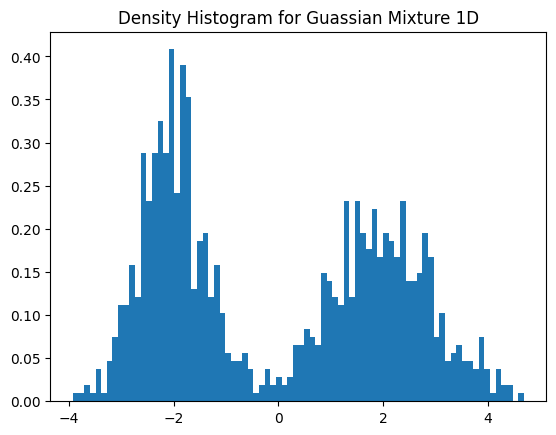

In [24]:
m1 = 2
m2 = -2
s1 = 1.0
s2 = 0.4

def generate_mixture_of_gaussians_1D(num_samples: int = 1000) -> np.ndarray:
    
    means = [[m1], [m2]]
    covs = [np.eye(1) * s1, np.eye(1) * s2]
    samples = []
    for mean, cov in zip(means, covs):
        samples.append(
            np.random.multivariate_normal(mean, cov, size=num_samples // len(means))
        )
    return np.vstack(samples)


mix = torch.distributions.categorical.Categorical(torch.ones(2,))
comp = torch.distributions.normal.Normal(torch.tensor([m1, m2]), torch.tensor([s1, s2]).sqrt())
gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

np.random.seed(0)
data_gaussians_1d = torch.tensor(generate_mixture_of_gaussians_1D(1000), dtype=torch.float32)
plt.hist(data_gaussians_1d.reshape(1,-1).squeeze().numpy(), bins=80, density=True)
plt.title('Density Histogram for Guassian Mixture 1D')
plt.show()

With similar simplifications of the loss as in DDPM we consider the following loss function:

$\mathbb{E}_{t \sim U(0, 1)} \; \mathbb{E}_{x_0 \sim q(x_0)} \; \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \lVert \epsilon - \epsilon_\theta(x_t, t) \rVert_2^2$

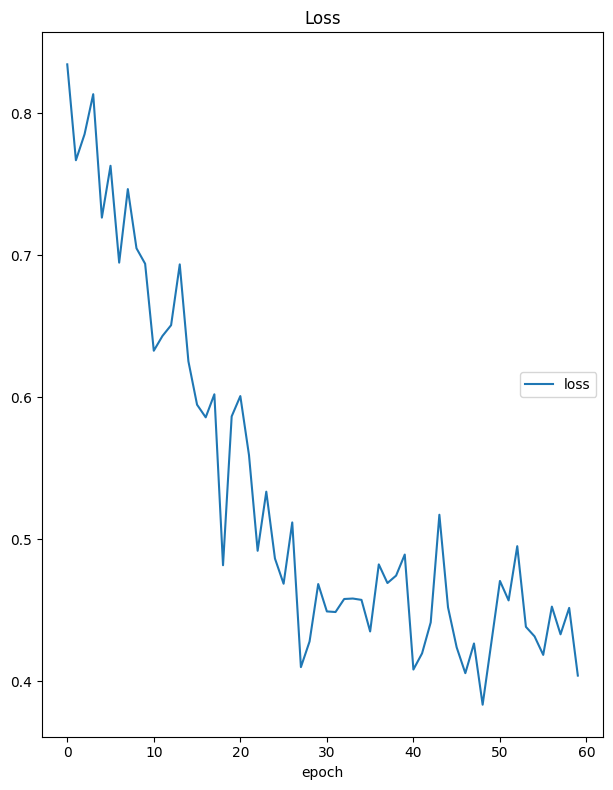

Loss
	loss             	 (min:    0.383, max:    0.834, cur:    0.404)


In [25]:
# Get the torch dataloader
dataloader_train_1d_pts = torch.utils.data.DataLoader(data_gaussians_1d, batch_size = 128, shuffle = True)

# Training loop
num_epochs = 60

model = NoisePredictorNetwork(in_dim=1, 
                              hidden_size=128, 
                              emb_size=128, 
                              out_dim=1)

# Declare the optimizer
optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-4,
    )
    
criterion = nn.MSELoss()

noise_scheduler_1d_pts = ScorebasedNoiseScheduler(beta)

train_scorebased_model(model = model, 
                       criterion = criterion, 
                       optimizer = optimizer, 
                       num_epochs = num_epochs, 
                       dataloader_train = dataloader_train_1d_pts, 
                       noise_scheduler = noise_scheduler_1d_pts, 
                       device = DEVICE)

Here is a visualization of the backward process, where you can choose the number of samples and the number of timesteps in Euler-Maruyama method.

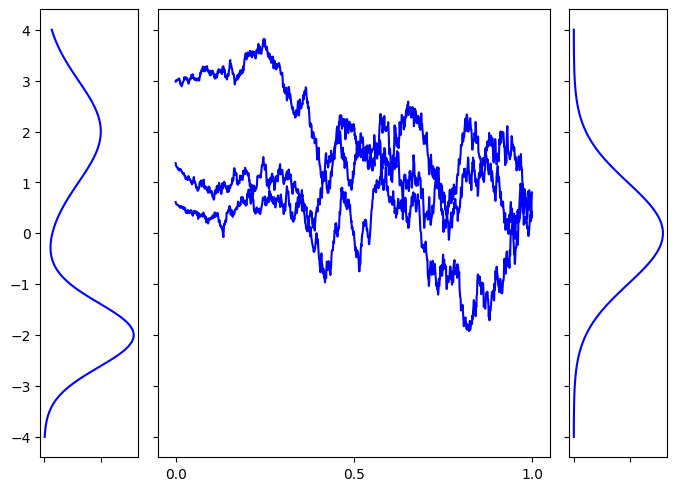

In [26]:
num_timesteps = 1000
num_samples = 3

steps = noise_scheduler_1d_pts.sample(model, num_samples, DEVICE, (1,), num_timesteps)
plot_1d_trajectories(steps, gmm)

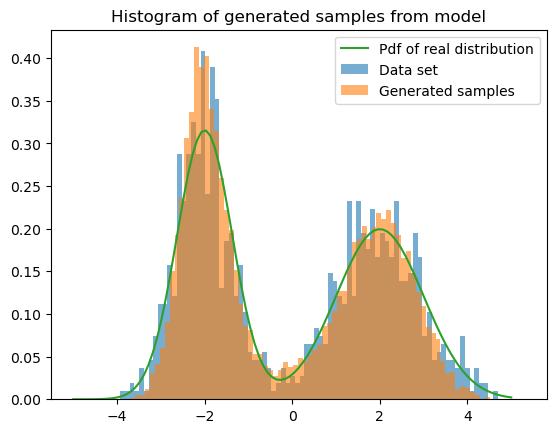

In [58]:
num_timesteps = 1000

samples = noise_scheduler_1d_pts.sample(model, 10000, DEVICE, (1,), num_timesteps)
plt.hist(data_gaussians_1d.reshape(1, -1).squeeze().numpy(), density=True, bins=80, alpha=0.6)
plt.hist(samples[-1].reshape(1,-1).squeeze().numpy(), bins=80, density=True, alpha=0.6)
plt.plot(np.linspace(-5, 5, 100), gmm.log_prob(torch.linspace(-5, 5, 100)).exp())
plt.legend(['Pdf of real distribution', 'Data set', 'Generated samples'])
plt.title('Histogram of generated samples from model')
plt.show()

## Image generation using DDPM

We now go back to the discrete approach of DDPM. We will use it for an image generation task. We will work with Fashion-MNIST dataset, which is low-res yet ntersting for the genrative task.

First let us (download and) visualize a few samples from the data.

Found cached dataset fashion_mnist (/cephyr/users/tobiaka/Alvis/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00,  3.45it/s]
/apps/Arch/software/PyTorch/1.12.1-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


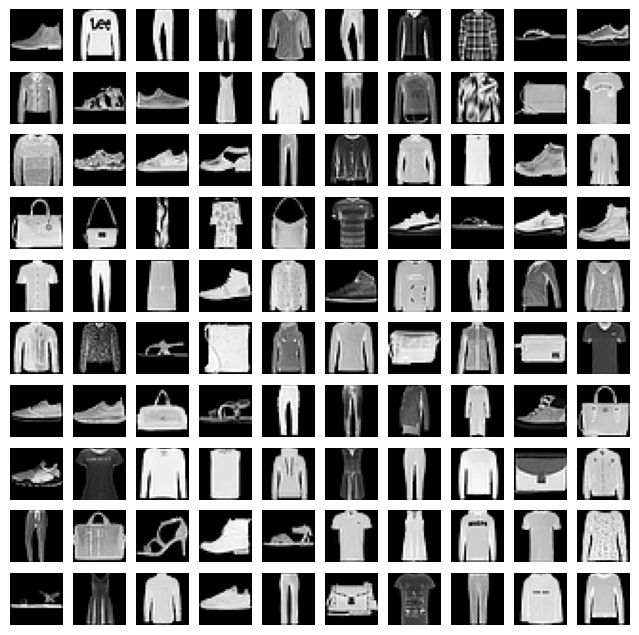

In [9]:
# Tunable Parameters
batch_size = 256
num_timesteps = 1000
unet_dim = 28

CHANNEL = 1
IMAGE_SIZE = 28

dataloader_train, dataloader_val = get_fashion_data(batch_size)

plot_fashion(dataloader_val, OUTPUT_DIR)

For the Image genration task, we can use the same NoiseScheduler class that we defined before, however we would need a more complex network for handling image features. As widely used, we will use a U-Net architecture as the noise predictor method. Below we provide some nessecary blocks in order to construct the U-Net. 

In [10]:
def Upsample(dim, dim_out):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, dim_out, 3, padding=1),
    )


def Downsample(dim, dim_out):
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, dim_out, 1),
    )


class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", torch.var)
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=4):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, time_emb_dim, groups=4):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        time_emb = self.mlp(time_emb)
        time_emb = rearrange(time_emb, "b c -> b c 1 1")
        scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = torch.einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = torch.einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

Here we will implement a U-net architecture that we propose - with three arguments `dim`, `time_dim`, and `channels`:
1. `dim` = (int) desired dimension of network structure (corresponds to the z-dimension).
2. `time_dim` = (int) desired dimension of time embedding.
3. `channels` = (int) number of channels the data have.

You need to fill in what input dimension the symbol $\cdot$ corresponds to.

The forward function is already implemented. Of course you can try other architectures if you want. Note that the test will, however, check this particular structure. 


### Time Embedding for t uses a MLP:
1. Apply sinusoidal position embedding, dimension of time embedding equal to `time_dim`
2. Linear($\cdot$, `time_dim`), with output layer with `time_dim` units
3. GELU activation
4. Linear($\cdot$, `time_dim`), with output layer with `time_dim` units

### Encoder:

**Block1:**
1. ResnetBlock(`dim`, `dim`, `time_dim`), input dimension as `dim`, output as `dim` and time embedding as `time_dim`
2. ResnetBlock($\cdot$, `dim`, `time_dim`), output dimension as `dim` and time embedding as `time_dim`
3. Residual(PreNorm($\cdot$, LinearAttention($\cdot$))) (does not change dimension)
4. Downsample($\cdot$, `dim`), output as `dim`      
(Note that Downsample also include convolutional-layer and therefore can the number of output channel be decided)

**Block2:**
1. ResnetBlock($\cdot$, `dim`, `time_dim`), output as `dim` and time embedding as `time_dim`
2. ResnetBlock($\cdot$, `dim`, `time_dim`), output dimension as `dim` and time embedding as `time_dim`
3. Residual(PreNorm($\cdot$, LinearAttention($\cdot$))) (does not change dimension)
4. Downsample($\cdot$, 2 * `dim`), output as 2 * `dim`    
(Note that Downsample also include convolutional-layer and therefore can the number of output channel be decided)

**Block3:**
1. ResnetBlock($\cdot$, 2 * `dim`, `time_dim`), output as 2 * `dim` and time embedding as `time_dim`
2. ResnetBlock($\cdot$, 2 * `dim`, `time_dim`), output dimension as 2 * `dim` and time embedding as `time_dim`
3. Residual(PreNorm($\cdot$, LinearAttention($\cdot$))) (does not change dimension)
4. Conv2D($\cdot$, 4 * `dim`, kernel_size=3, padding=1), output as 4 * `dim`, kernel size=3, padding=1 **(Note not downsample)**

### Latent Block:
1. ResnetBlock($\cdot$, 4 * `dim`, `time_dim`), output as 4 * `dim` and time embedding as `time_dim`
2. Residual(PreNorm($\cdot$, Attention($\cdot$))) (does not change dimension)
3. ResnetBlock($\cdot$, 4 * `dim`, `time_dim`), output as 4 * `dim` and time embedding as `time_dim`

### Decoder:

**Block1:**
1. ResnetBlock($\cdot$, 4 * `dim`, `time_dim`), 
* dimension of input is equal to dim(Encoder Block3-3 output) + dim(Latent Block output) 
* dimension of output is equal to 4 * `dim` and dimension of time embedding is equal to `time_dim`
2. ResnetBlock($\cdot$, 4 * `dim`, `time_dim`), 
* dimension of input is equal to dim(Encoder Block3-1 output) + dim(previous output)
* dimension of output is equal to 4 * `dim` and dimension of time embedding is equal to `time_dim`
3. Residual(PreNorm($\cdot$, LinearAttention($\cdot$))) (does not change dimension)
4. Upsample($\cdot$, 2 * `dim`), output is equal to 2 * `dim`    
(Note that Upsample also include convolutional-layer and therefore can the number of output channel be decided)

**Block2:**
1. ResnetBlock($\cdot$, 2 * `dim`, `time_dim`), 
* dimension of input is equal to dim(Encoder Block2-3 output) and dim(previous output)
* dimension of output is equal to 2 * `dim` and time embedding is equal to `time_dim`
2. ResnetBlock($\cdot$, 2 * `dim`, `time_dim`), 
* dimension of input is equal to dim(Encoder Block2-1 output) + dim(previous output)
* dimension of output is equal to 2 * `dim` and time embedding is equal to `time_dim`
3. Residual(PreNorm($\cdot$, LinearAttention($\cdot$))) (does not change dimension)
4. Upsample($\cdot$, `dim`), output is equal to `dim`    
(Note that Upsample also include convolutional-layer and therefore can the number of output channel be decided)

**Block3:**
1. ResnetBlock($\cdot$, `dim`, `time_dim`), 
* dimension of input is equal to dim(Encoder Block1-3 output) and dim(previous output)
* dimension of output is equal to `dim` and time embedding is equal to `time_dim`
2. ResnetBlock($\cdot$, `dim`, `time_dim`), 
* dimension of input is equal to dim(Encoder Block1-1 output) + dim(previous output)
* dimension of output is equal to `dim` and time embedding is equal to `time_dim`
3. Residual(PreNorm($\cdot$, LinearAttention($\cdot$))) (does not change dimension)
4. Conv2D($\cdot$, `dim`, kernel_size=3, padding=1), output is equal to `dim`, kernel size=3, padding=1 **(Note not upsample)**

In [11]:
class Unet(nn.Module):
    def __init__(
        self,
        dim: int,
        time_dim: int = 112,
        channels: int = 1,
    ):
        # Input
        # dim = (int) desired dimension of network structure (corresponds to the z-dimension).
        # time_dim = (int) desired dimension of time embedding.
        # channels = (int) number of channels the data have.
        super().__init__()

        # Dimensions
        self.channels = channels
        self.dim = dim
        self.time_dim = time_dim
        
        # First & Final Layers
        self.init_conv = nn.Conv2d(channels, dim, 1, padding=0)
        self.final_res_block = ResnetBlock(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, channels, 1)

        # Layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        
        # YOUR CODE HERE
        # Time Embedding
        self.time_mlp = nn.Sequential(*[SinusoidalPositionEmbeddings(time_dim), nn.Linear(time_dim, time_dim), nn.GELU(), nn.Linear(time_dim, time_dim)])
        
        # Encoder 
        # Block 1
        self.downs.append(nn.ModuleList([ResnetBlock(dim, dim, time_dim), ResnetBlock(dim, dim, time_dim), Residual(PreNorm(dim, LinearAttention(dim))), Downsample(dim, dim)]))
        # Block 2
        self.downs.append(nn.ModuleList([ResnetBlock(dim, dim, time_dim), ResnetBlock(dim, dim, time_dim), Residual(PreNorm(dim, LinearAttention(dim))), Downsample(dim, 2*dim)]))
        # Block 3
        self.downs.append(nn.ModuleList([ResnetBlock(2*dim, 2*dim, time_dim), ResnetBlock(2*dim, 2*dim, time_dim), Residual(PreNorm(2*dim, LinearAttention(2*dim))), nn.Conv2d(2*dim, 4*dim, 3, 1, 1)]))
        
        # Latent Layer
        self.middle = nn.ModuleList([ResnetBlock(4*dim, 4*dim, time_dim), Residual(PreNorm(4*dim, Attention(4*dim))), ResnetBlock(4*dim, 4*dim, time_dim)])
        
        # Decoder
        # Block 1
        self.ups.append(nn.ModuleList([ResnetBlock((2+4)*dim, 4*dim, time_dim), ResnetBlock((2+4)*dim, 4*dim, time_dim), Residual(PreNorm(4*dim, LinearAttention(4*dim))), Upsample(4*dim, 2*dim)]))
        # Block 2
        self.ups.append(nn.ModuleList([ResnetBlock((1+2)*dim, 2*dim, time_dim), ResnetBlock((1+2)*dim, 2*dim, time_dim), Residual(PreNorm(2*dim, LinearAttention(2*dim))), Upsample(2*dim, dim)]))
        # Block 3
        self.ups.append(nn.ModuleList([ResnetBlock((1+1)*dim, dim, time_dim), ResnetBlock((1+1)*dim, dim, time_dim), Residual(PreNorm(dim, LinearAttention(dim))), nn.Conv2d(dim, dim, 3, 1, 1)]))


    def unet_forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.init_conv(x)
        r = x.clone()

        h = []

         # Down-sampling
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)
        
        # Latent Space
        for block in self.middle:
            x = block(x, t) if type(block) is ResnetBlock else block(x)

        # Up-sampling
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

    def forward(self, x: torch.Tensor, time: torch.Tensor):
        t = self.time_mlp(time)
        return self.unet_forward(x, t)

In [12]:
test_unet(Unet)

AssertionError: 

A. Nichol and P. Dhariwal (Improved Denoising Diffusion Probabilistic Models) proposed an improved beta schedule (compared to the linear one).

The beta schedule is defined by $\bar{\alpha}_t$ in the following way:

$\beta_t = \min \Biggl(1 - \dfrac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}, \beta_{\max} \Biggr)$, where $\bar{\alpha}_t = \dfrac{f(t)}{f(0)}$ and $f(t) = \cos \Biggl( \dfrac{t/T + s}{1 + s} \cdot \dfrac{\pi}{2} \Biggr)^2$

$T$ is the total number of timesteps, $\beta_{\max} = 0.999$, and $s = 0.008$.

In [13]:
def beta_schedule_improved(num_timesteps: int, s: float = 0.008, beta_max: float = 0.999) -> torch.Tensor:
    # Input: num_timesteps (corresponds to T in the fomula above),
    #        s,
    #        beta_max

    # Output: beta_t, for all t = 1,...,T as a torch.Tensor
    
    s = torch.tensor(s)
    ts = torch.arange(1, num_timesteps + 1)
    fts = torch.cos((ts/num_timesteps + s)/(1+s) * (np.pi/2)) ** 2
    f0 = torch.cos(s/(1+s) * (torch.pi/2)) ** 2
    alpha_bars = fts / f0
    alpha_bars_1 = torch.cat((torch.tensor([1.0]), alpha_bars[:-1]))
    return torch.min(1 - alpha_bars/alpha_bars_1, torch.tensor(beta_max))

In [14]:
test_improved_beta_schedule(beta_schedule_improved)

✓ Value test passed! 


In the plots below we can see the difference in $\bar{\alpha}_t$ between the linear beta schedule and the improved beta schedule (with the same $\beta_{\rm start}$ and $\beta_{\rm end}$ but with different values of $T$, the total number of time steps). Reason why this back-engineered beta schedule is an improvement.

Since one network is used for all timestep predictions it is important to consider how much we care about being accurate at different levels of noise. With the improved scheduler above, more emphasis is put on the less noisy samples, i.e timesteps close to zero. This makes sense since this is the part where it is important to perform well in order to achive high resolution samples.

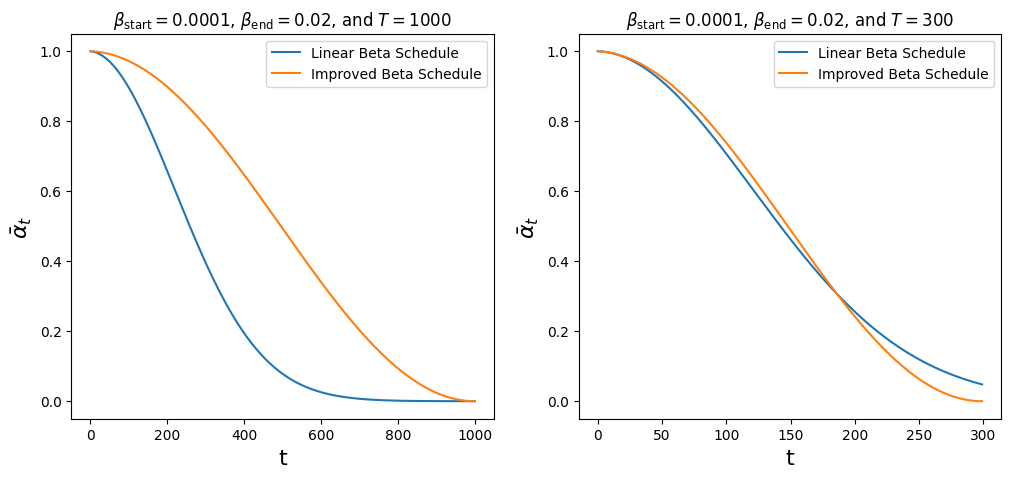

In [38]:
compare_beta_schedules(linear_beta_schedule, beta_schedule_improved)

In [42]:
batch_size = 1024
unet = Unet(dim=unet_dim).to(DEVICE)
noise_scheduler = NoiseScheduler(beta_schedule_improved, num_timesteps)

diffm = DiffusionModel(model=unet,
                       loss_f=F.mse_loss, 
                       noise_scheduler=noise_scheduler)

diffm.to(DEVICE)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=0)

/cephyr/users/tobiaka/Alvis/.local/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cephyr/users/tobiaka/Alvis/.local/lib/python3.10/si ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(diffm, dataloader_train, dataloader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.119     Total estimated model params size (MB)
/apps/Arch/software/PyTorch/1.12.1-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 19: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s, v_num=1063133] 19. Train Loss: 0.06745538118685412


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s, v_num=1063133]


In [44]:
unet.to(DEVICE)
samples = noise_scheduler.sample(unet, 100, DEVICE, (1, 28, 28))[0]

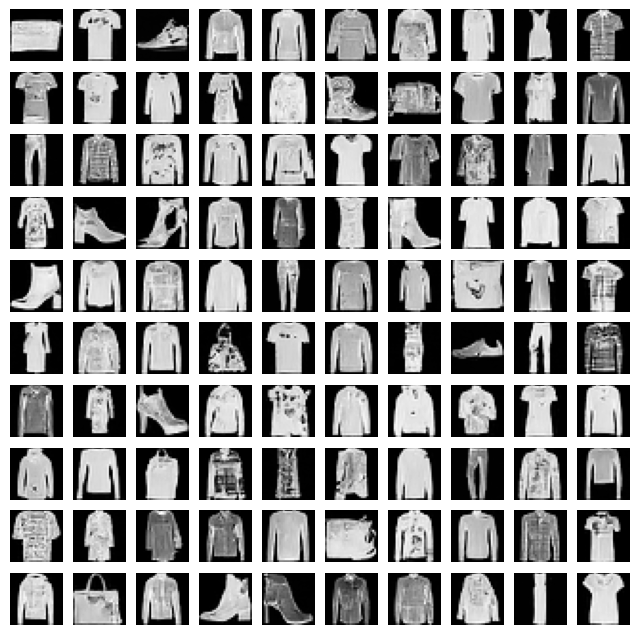

In [45]:
fig, axs = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(samples[i * 10 + j].squeeze(), cmap="gray")
        axs[i, j].axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "fashion_generated_samples.png"))
plt.show()

## Conditioning on Labels

There are several ways of conditioning on labels. However, in this case, when considering a simple dataset as fashion-MNIST a simple modification works fine: add (+) a label embedding with the time embedding.

Further, modify the sample function such that it handles label.

In [ ]:
class UnetCondtional(Unet):

    def __init__(self, 
                 dim, 
                 time_dim=112, 
                 channels=1,
                 num_classes=10):
        super().__init__(dim, time_dim, channels)
        self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, time, y):
        t = self.time_mlp(time)
        
        t += self.label_emb(y)
        return self.unet_forward(x, t)
    

class NoiseSchedulerConditional(NoiseScheduler):
    
    @torch.no_grad()
    def sample(self,
               model: nn.Module,
               num_samples: int,
               device: torch.device, 
               shape: tuple,
               label: int):
    
        # Sample points from the data distribution

        # Input: model (model to predict noise)
        #        num_samples (number of samples)
        #        device (the device the model is on)
        #        label (label to condition on)

        # Output: all x through the (predicted) reverse diffusion steps conditioned on the label
        
        model.eval()
        steps = {}
        
        print(device)
        model = model.to(device)
        x_tm1 = torch.randn((num_samples,) + shape).to(device)
        labels = torch.full((x_tm1.shape[0],), label, device=device)
        for t in reversed(range(0, self.num_timesteps)):
            t_tensor = torch.full((x_tm1.shape[0],), t, device=device)
            
            pred_noise = model(x_tm1, t_tensor, labels)
            x_tm1 = step_back(x_tm1, t, self.betas, self.alphas, self.alphas_bar, self.posterior_variance, pred_noise)
            steps[t+1] = x_tm1.detach().cpu()

        return x_tm1.detach(), steps

In [33]:
cond_unet = UnetCondtional(dim=unet_dim).to(DEVICE)
cond_noise_scheduler = NoiseSchedulerConditional(beta_schedule_improved, num_timesteps, 'beta_tilde')

diffc = DiffusionModelConditional(model=cond_unet, 
                                  loss_f=F.smooth_l1_loss, 
                                  noise_scheduler=cond_noise_scheduler)

diffc.to(DEVICE)
trainer = pl.Trainer(max_epochs=5, num_sanity_val_steps=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(diffc, dataloader_train, dataloader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | UnetCondtional | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.123     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 234/234 [01:16<00:00,  3.06it/s, v_num=1063441] 4. Train Loss: 0.03492450365462364


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 234/234 [01:16<00:00,  3.06it/s, v_num=1063441]


In [ ]:
samples = [cond_noise_scheduler.sample(cond_unet, 10, "cpu", (1, 28, 28), i)[0] for i in range(10)]

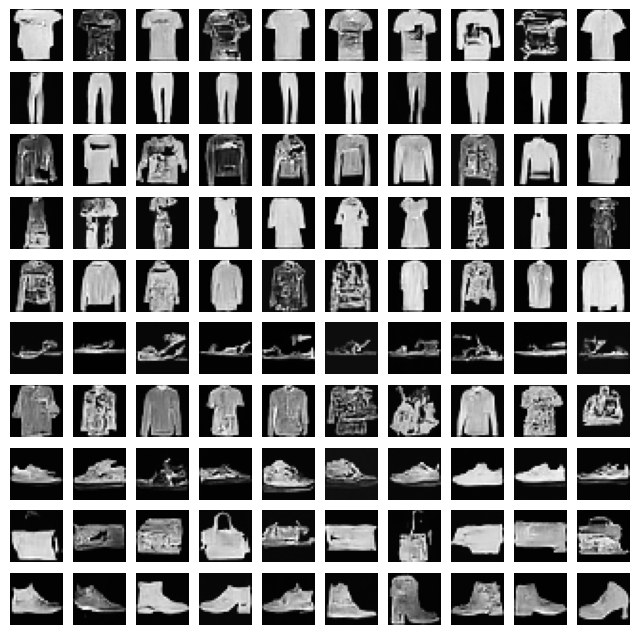

In [36]:
fig, axs = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(samples[i][j].squeeze(), cmap="gray")
        axs[i, j].axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "fashion_generated_samples_condition.png"))
plt.show()

Elaborate about what advantages and disadvantages diffusion models have. Especially compared to all the other models we have learned about in this course.

Diffusion models are an intuitive and simple idea which seem to work very well in practice. They are flexible when it comes to model architecture. Disadvantages are that they are quite computationally demanding and not notion of latent space.